In [41]:
import pandas as pd
import numpy  as np
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import seaborn                 as     sns
from   mpl_toolkits.mplot3d    import Axes3D
from   sklearn.linear_model    import LinearRegression
from   sklearn.neural_network  import MLPRegressor
from   sklearn.metrics         import mean_squared_error
from   sklearn.model_selection import cross_val_score,TimeSeriesSplit

In [10]:
#Reach the terminal
mt5.initialize()

True

In [27]:
#Define the input range
x_min , x_max = 2,100 #Look ahead
y_min , y_max = 2,100 #Period

In [28]:
#Sample input range uniformly
x_axis = np.arange(x_min,x_max,2) #Look ahead
y_axis = np.arange(y_min,y_max,2) #Period

In [29]:
#Create a meshgrid
x , y = np.meshgrid(x_axis,y_axis)

In [59]:
def clean_data(look_ahead,period):
    #Fetch the data from our terminal and clean it up 
    data = pd.DataFrame(mt5.copy_rates_from_pos('AUDJPY',mt5.TIMEFRAME_D1,365*2,5000))
    data['time'] = pd.to_datetime(data['time'],unit='s')
    data['MA'] = data['close'].rolling(period).mean()
    #Transform the data
    #Target
    data['Target'] = data['MA'].shift(-look_ahead) - data['MA']
    #Change in price
    data['close']  = data['close'] - data['close'].shift(period)
    #Change in MA
    data['MA']  = data['MA'] - data['MA'].shift(period)
    data.dropna(inplace=True)
    data.reset_index(drop=True,inplace=True)
    return(data)

In [63]:
#Evaluate the objective function
def evaluate(look_ahead,period):
    #Define the model
    model = LinearRegression()
    #Define our time series split
    tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)
    temp = clean_data(look_ahead,period)
    score = np.mean(cross_val_score(model,temp.loc[:,["MA"]],temp["Target"],cv=tscv))
    return(score)

In [64]:
#Define the objective
def objective(x,y):
    #Define the output matrix
    results = np.zeros([x.shape[0],y.shape[0]])
    #Fill in the output matrix
    for i in np.arange(0,x.shape[0]):
        #Select the rows
        look_ahead = x[i]
        period     = y[i]
        for j in np.arange(0,y.shape[0]):
            results[i,j] = evaluate(look_ahead[j],period[j])
    return(results)

In [65]:
res = objective(x,y)
res = np.abs(res)

Text(0.5, 1.0, 'Linear Regression Accuracy Forecasting AUDJPY Daily Return')

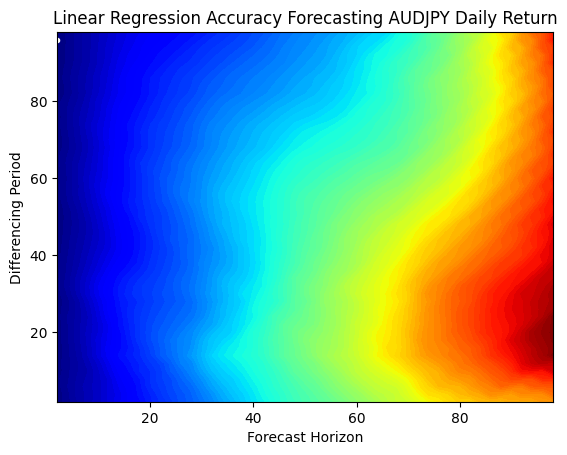

In [57]:
plt.contourf(x,y,res,100,cmap="jet")
plt.plot(x_axis[res.min(axis=0).argmin()],y_axis[res.min(axis=1).argmin()],'.',color='white')
plt.ylabel("Differencing Period")
plt.xlabel("Forecast Horizon")
plt.title("Linear Regression Accuracy Forecasting AUDJPY Daily Return")

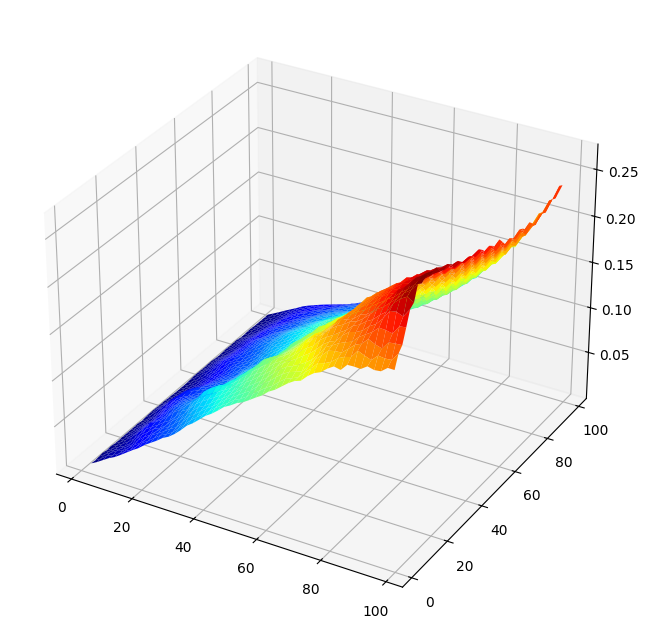

In [58]:
#Create a surface plot
fig , ax = plt.subplots(subplot_kw={"projection":"3d"})
fig.set_size_inches(8,8)
ax.plot_surface(x,y,res,cmap="jet")

Text(0.5, 1.0, 'Linear Regression Accuracy Forecasting AUDJPY Daily Moving Average Return')

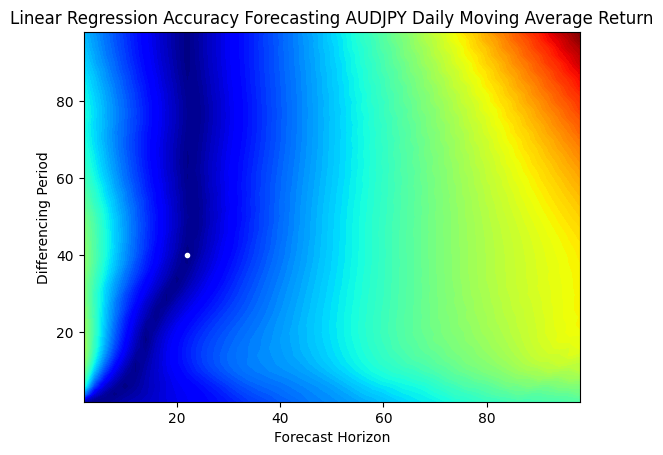

In [66]:
plt.contourf(x,y,res,100,cmap="jet")
plt.plot(x_axis[res.min(axis=0).argmin()],y_axis[res.min(axis=1).argmin()],'.',color='white')
plt.ylabel("Differencing Period")
plt.xlabel("Forecast Horizon")
plt.title("Linear Regression Accuracy Forecasting AUDJPY Daily Moving Average Return")

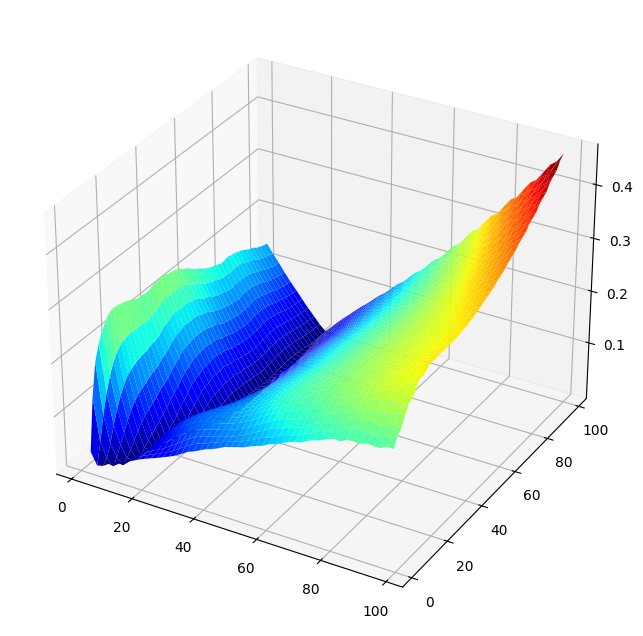

In [67]:
#Create a surface plot
fig , ax = plt.subplots(subplot_kw={"projection":"3d"})
fig.set_size_inches(8,8)
ax.plot_surface(x,y,res,cmap="jet")

In [68]:
#Optimal inputs
x_axis[res.min(axis=0).argmin()],y_axis[res.min(axis=1).argmin()]

(22, 40)